In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Creating functions for curve_fit
def gaussian(x, amplitude, mu, sigma, y_offset):
    return amplitude * np.exp(-((x - mu)**2) / (2 * sigma**2)) + y_offset

def gaussian_fit(A, B, C, D, xdata, ydata):
    """
    A = Amplitude
    B = Mean
    C = Sigma
    D = Y Offset
    """
    popt, pcov = curve_fit(gaussian, xdata, ydata, 
                          p0=[A, B, C, D]) 

    amplitude, mean, sigma, vertical_offset = popt
    sigma_amp, sigma_mean, sigma_std, sigma_b = np.sqrt(np.diag(pcov))
    
    # Function automatically plots the data
    plt.scatter(xdata, ydata, label="Data", marker='.')
    plt.plot(xdata, gaussian(xdata, *popt), label="Best Fit", color="red")
    plt.legend()
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Current (mA)")
    plt.show()
    
    return amplitude, mean, sigma, vertical_offset, sigma_amp, sigma_mean, sigma_std, sigma_b

# Calibrating spectrometer using mercury data

Mercury has a known spectral line at a wavelength of 546.0735 nm. By using a tube of mercury plasma in front of the spectrometer, and while collecting atmospheric data to determine the index of refraction of the local air, we can calibrate the spectrometer to allow for more accurate results. We took data for the atmosphere's pressure, temperature, and humidity, using the NIST website to get an estimate for n. As $\lambda_{air} = \lambda_{vac}/n$, we can then place the start and end wavelengths to scan at around one nanometer on either side of the expected $\lambda_{air}$ with an increment of 0.01 nms and an integration time of 0.05 seconds. 

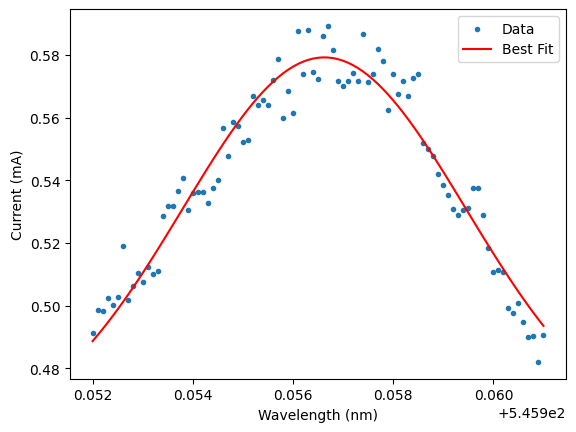

Wavelength = 545.9566 nm +/- 3.8278e-05 nm

Amplitude: 0.1228 mA, Mean: 5.4596e+02, Sigma: 2.8247e-03, y_offset: 4.5650e-01
Uncertainty in amplitude: 1.2884e-02, Uncertainty in mean: 3.8278e-05
Sigma standard deviation: 2.5863e-04, Uncertainty in y offset: 1.3595e-02


In [33]:
# Calibrating Mercury Data
mercury = pd.read_csv("Hg-calibration.csv")

# set x and y axes
hg_wavelength = mercury.iloc[:, 0].values
hg_current = mercury.iloc[:, 1].values

# set cutoffs to make plot symmetrical
min_cutoff = 545.952
max_cutoff = 545.961
filtered_indices = (hg_wavelength >= min_cutoff) & (hg_wavelength <= max_cutoff)
filtered_wavelength = hg_wavelength[filtered_indices]
filtered_current = hg_current[filtered_indices]

# Estimates for gaussian function
A = 0.1
B = 545.957
C = 0.001
D = 0.4

amplitude, mean, sigma, vertical_offset, sigma_amp, sigma_mean, sigma_std, sigma_b = gaussian_fit(A, B, C, D, filtered_wavelength, filtered_current)
print(f'Wavelength = {mean:.4f} nm +/- {sigma_mean:.4e} nm')
print()
print(f"Amplitude: {amplitude:.4f} mA, Mean: {mean:.4e}, Sigma: {sigma:.4e}, y_offset: {vertical_offset:.4e}")
print(f"Uncertainty in amplitude: {sigma_amp:.4e}, Uncertainty in mean: {sigma_mean:.4e}")
print(f"Sigma standard deviation: {sigma_std:.4e}, Uncertainty in y offset: {sigma_b:.4e}")

After doing this fit, we are then able to calibrate the spectrometer in order to get more accurate data on the H2D2 spectra.

# Finding n (H-$\alpha$ 3 $\to$ 2)
In order to detect the first line in the Balmer Series, and each line afterwards, we first must find the index of refraction (n) given the atmospheric conditions at the time of our experiment. This step will be repeated for each new Balmer line in order to make it easier to find the spectra with the Horiba / Jobin-Yvon Spectrometer. After measuring the atmospheric pressure, relative humidity, and temperature, we can input our readings into the [NIST website](https://emtoolbox.nist.gov/Wavelength/Edlen.asp) once again and use the calculated value of n to estimate where we should expect to detect one of the emission spectra.

pressure = 0.8147 barr

humidity = 8.3%

temp = 21.6 C

n = 1.000217038

$\lambda_{vac}$ = 656.11224

$\lambda_{air}$ = 655.9698

Now, we can upload the data for this spectra and begin fitting a gaussian to our data.

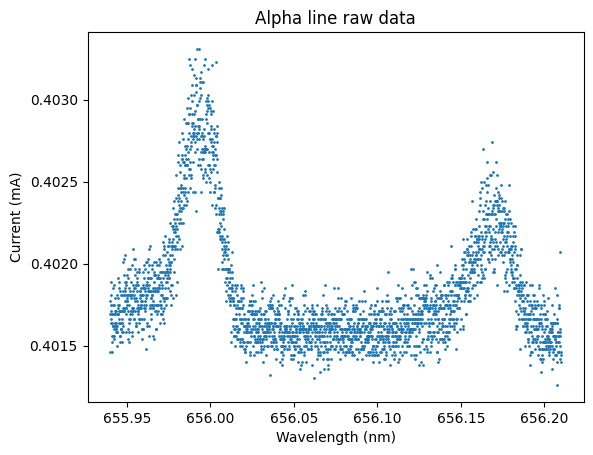

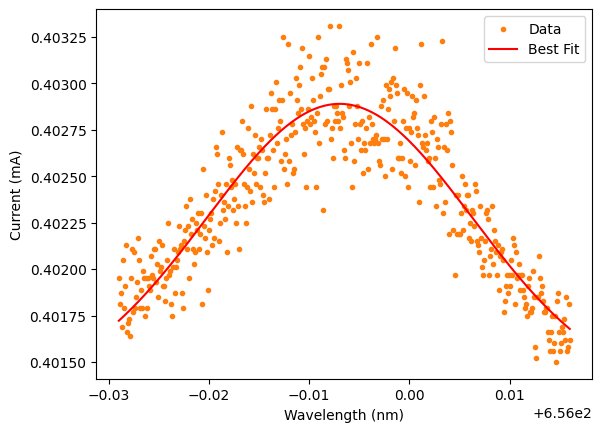

Hydrogen Alpha Line:
Wavelength = 655.9930 nm +/- 0.0002 nm
Amplitude: 0.0016 mA +/- 0.0001 mA
Sigma: 0.0132 +/- 0.0009
Y offset: 0.4013 mA +/- 0.0001 mA


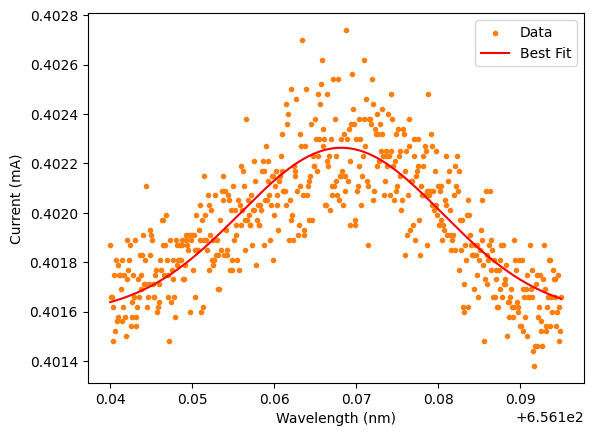

Deuterium Alpha Line:
Wavelength = 656.1682 nm +/- 0.0003 nm
Amplitude: 0.0007 mA +/- 3.1610e-05 mA
Sigma: 0.0123 +/- 0.0007
Y offset: 0.4016 mA +/- 3.4518e-05 mA


In [75]:
h2d2_alpha = pd.read_csv("h2d2-alpha3-2.csv", skiprows=0)

# set x and y axes
alpha_wavelength = h2d2_alpha.iloc[:, 0].values
alpha_current = h2d2_alpha.iloc[:, 1].values

plt.scatter(alpha_wavelength, alpha_current, s=1)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Current (mA)')
plt.title('Alpha line raw data')
plt.show()

# Splitting data into Hydrogen and Deuterium
he_alpha_min_cutoff = 655.971
he_alpha_max_cutoff = 656.016

filtered_he_alpha_indices = (alpha_wavelength >= he_alpha_min_cutoff) & (alpha_wavelength <= he_alpha_max_cutoff)
filtered_he_alpha_wavelength = alpha_wavelength[filtered_he_alpha_indices]
filtered_he_alpha_current = alpha_current[filtered_he_alpha_indices]

# Hydrogen alpha line first
plt.scatter(filtered_he_alpha_wavelength, filtered_he_alpha_current, s=1)
A_he = 0.00075
B_he = 656
C_he = 0.002
D_he = 0.402
he_alpha_amplitude, he_alpha_mean, he_alpha_sigma, he_alpha_vertical_offset, he_alpha_sigma_amp, he_alpha_sigma_mean, he_alpha_sigma_std, he_alpha_sigma_b = gaussian_fit(A_he, B_he, C_he, D_he, filtered_he_alpha_wavelength, filtered_he_alpha_current)
print(f'Hydrogen Alpha Line:')
print(f'Wavelength = {he_alpha_mean:.4f} nm +/- {he_alpha_sigma_mean:.4f} nm')
print(f"Amplitude: {he_alpha_amplitude:.4f} mA +/- {he_alpha_sigma_amp:.4f} mA")
print(f'Sigma: {he_alpha_sigma:.4f} +/- {he_alpha_sigma_std:.4f}')
print(f"Y offset: {he_alpha_vertical_offset:.4f} mA +/- {he_alpha_sigma_b:.4f} mA")

# Deuterium alpha line
de_alpha_min_cutoff = 656.14
de_alpha_max_cutoff = 656.195

filtered_de_alpha_indices = (alpha_wavelength >= de_alpha_min_cutoff) & (alpha_wavelength <= de_alpha_max_cutoff)
filtered_de_alpha_wavelength = alpha_wavelength[filtered_de_alpha_indices]
filtered_de_alpha_current = alpha_current[filtered_de_alpha_indices]

plt.scatter(filtered_de_alpha_wavelength, filtered_de_alpha_current, s=1)
A_de = 0.0012
B_de = 656.168
C_de = 0.003
D_de = 0.4009

de_alpha_amplitude, de_alpha_mean, de_alpha_sigma, de_alpha_vertical_offset, de_alpha_sigma_amp, de_alpha_sigma_mean, de_alpha_sigma_std, de_alpha_sigma_b = gaussian_fit(A_de, B_de, C_de, D_de, filtered_de_alpha_wavelength, filtered_de_alpha_current)
print(f'Deuterium Alpha Line:')
print(f'Wavelength = {de_alpha_mean:.4f} nm +/- {de_alpha_sigma_mean:.4f} nm')
print(f"Amplitude: {de_alpha_amplitude:.4f} mA +/- {de_alpha_sigma_amp:.4e} mA")
print(f'Sigma: {de_alpha_sigma:.4f} +/- {de_alpha_sigma_std:.4f}')
print(f"Y offset: {de_alpha_vertical_offset:.4f} mA +/- {de_alpha_sigma_b:.4e} mA")

# Finding n (4-2)
pressure = 0.8147 barr

humidity = 9.8%

temp = 21.8 C

n = 1.000219315

$\lambda_{vac}$ = 486.0091

$\lambda_{air}$ = 485.902534

# Finding n (5-2)

pressure = 0.8154 barr

humidity = 7.5

temp = 21.5 C

n = 1.000222019

$\lambda_{vac}$ = 410.0702

$\lambda_{air}$ = 409.979177